# Light GBM Classifier on cifar-100 (Model 2)

### Load google drive to refer to dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load required libraries

In [2]:
# %tensorflow_version 1.x
from __future__ import print_function

import pickle
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import collections
import xgboost as xgb
import lightgbm as lgbm
import joblib
import time
from time import gmtime, strftime, localtime

# sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, maxabs_scale, minmax_scale
from sklearn.decomposition import PCA

# keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, PReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers

Using TensorFlow backend.


### File path to cifar-100
- The data has to be present under user's colab notebook directory.
- Adjust file_path if required, and it will take effect through out this notebook

In [0]:
# Google Colab run
file_path = '/content/drive/My Drive/Colab Notebooks/cifar-100-python/'

# Local run
# file_path = 'cifar-100-python/'

### Unpickle python files
- Train - training set, 50000 images, 5 batches of 10000 images
- Test - test set, 10000 images
- Meta - label names

In [0]:
def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res

meta_raw = unpickle(file_path + 'meta')
train_raw = unpickle(file_path + 'train')
test_raw = unpickle(file_path + 'test')

### Explore Dataset and Sample images

Data as per RGB channel : (50000, 3, 1024)
Data as per RGB channel : (10000, 3, 1024)
RGB Data reshaped for matplotlib display : (50000, 32, 32, 3)


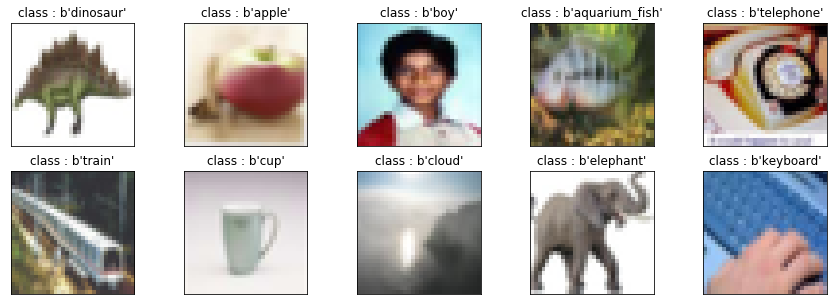

In [5]:
# display sample images
train_rgb = train_raw[b'data'].reshape(len(train_raw[b'data']),3,1024)
print("Data as per RGB channel : {}".format(train_rgb.shape))
test_rgb = test_raw[b'data'].reshape(len(test_raw[b'data']),3,1024)
print("Data as per RGB channel : {}".format(test_rgb.shape))

image_disp = train_raw[b'data'].reshape(len(train_raw[b'data']),3,32,32).transpose(0, 2, 3, 1)
print("RGB Data reshaped for matplotlib display : {}".format(image_disp.shape))

width = 10
height = 10
cols = 5
rows = 2
fig = plt.figure(figsize=(15, 5))

for i in range(1,11):
  plt.subplot(rows, cols, i)
  pixel = image_disp[i]
  image_label = train_raw[b'fine_labels'][i]
  plt.imshow(pixel, cmap=plt.get_cmap('gray'))
  plt.title("class : "  + str(meta_raw[b'fine_label_names'][image_label]) )
  plt.xticks([])
  plt.yticks([])
  
plt.show()

In [6]:
# Fetch Train and Test labels
train_labels = np.asarray(train_raw[b'fine_labels'])
test_labels = np.asarray(test_raw[b'fine_labels'])

print(train_labels.shape)
print(test_labels.shape)

(50000,)
(10000,)


### Image Pre-processing

In [0]:
# Standardise data
def standardize_data(x):
    """
        argument
            - input image data in numpy array [3, 1024]
        return
            - processed image 
    """
    mu = x.mean(0)
    stdv = x.std(0)
    # standard_x = x / 255           # Max division - output range 0 to 1
    # standard_x = (x - mu) / stdv   # Standardise mean and std
    # standard_x = x / stdv          # only by std
    standard_x = x                   # No proprocessing
    return standard_x

X_train = standardize_data(train_rgb)
X_test = standardize_data(test_rgb)

In [8]:
# Using sklearn preprocessing

X_train = X_train.reshape(50000,3072)
X_test = X_test.reshape(10000,3072)

X_train = minmax_scale(train_raw[b'data'], feature_range=(-1,1))
X_test = minmax_scale(test_raw[b'data'], feature_range=(-1,1))

print(X_train.shape, X_test.shape)
# Range after pre-processing
print(max(X_train[:,0]), min(X_train[:,0]))

(50000, 3072) (10000, 3072)
1.0 -1.0


#### Dimensionality Reduction
Principle Component Analysis (PCA) has been implemented to reduce dimension.
The aim to implement PCA was to improve the model performance and time of training.

In [9]:
pca = PCA(random_state = 1, n_components = 1000)
pca.fit(X_train)
sum(pca.explained_variance_ratio_)

0.9960582195001813

In [0]:
#Transform our training and validation data
PCA_x_train = pca.transform(X_train)
PCA_x_test = pca.transform(X_test)

## *Experiment Setup*

In [11]:
# registering time for perfomance measurement
start = time.time()
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

Fri, 08 Nov 2019 04:29:20 +0000


#### Hyper Parameter Grid

In [0]:
# parameter for grid search
parameters = {"learning_rate": [0.01, 0.1]}

#### Define 10-fold cross validation to find best set of hyper parameters

In [0]:
# Scoring F1_mirco
lgbm_clf = lgbm.LGBMClassifier(verbosity = 2,
                               min_child_weight=4,    # Conservative model to avoid overfitting
                               subsample=0.5,         # Limited samples for fast processing
                               colsample_bytree=1,    # Reduced number of features (out of 3072) for fast processing if not using PCA
                               n_estimators=20,
                               max_depth=4,
                               objective = "multiclass")

lgbm_rscv = GridSearchCV(estimator=lgbm_clf,
                         param_grid = parameters,
                         scoring = "f1_micro",
                         n_jobs=-1,
                         cv = 10)

#### Train using experiment setup



In [14]:
# Train the model
model_lgbm = lgbm_rscv.fit(PCA_x_train, train_labels)

print("Best: %f using %s" % (lgbm_rscv.best_score_, lgbm_rscv.best_params_))
print(lgbm_rscv.cv_results_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.112000 using {'max_depth': 6, 'learning_rate': 0.1}
{'mean_fit_time': array([31.52062452, 46.4610287 , 31.35360591, 46.73320839]), 'std_fit_time': array([0.73376618, 0.43374882, 0.70633795, 0.57696455]), 'mean_score_time': array([0.05775361, 0.06598966, 0.0549119 , 0.05890491]), 'std_score_time': array([0.01220433, 0.01376965, 0.00453557, 0.00051809]), 'param_max_depth': masked_array(data=[4, 6, 4, 6],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.1, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 4, 'learning_rate': 0.01}, {'max_depth': 6, 'learning_rate': 0.01}, {'max_depth': 4, 'learning_rate': 0.1}, {'max_depth': 6, 'learning_rate': 0.1}], 'split0_test_score': array([0.1102, 0.1118, 0.1102, 0.1118]), 'split1_test_score': array([0.1144, 0.1176, 0.1144, 0.1176]), 'split2_test_score': array(

In [0]:
# import lightgbm as lgbm
# lgbm_clf = lgbm.LGBMClassifier(verbosity = 2,
#                                learning_rate=0.01,
#                                max_depth=4,
#                                min_child_weight=4,
#                                n_estimators=50,
#                                subsample=0.5,
#                                colsample_bytree=1.0,
#                                objective = "multiclass")

In [0]:
# Predictions on train and test set
y_train_preds = model_lgbm.predict(PCA_x_train)
y_test_preds = model_lgbm.predict(PCA_x_test)

# y_train_preds = lgbm_clf.predict(PCA_x_train)
# y_test_preds = lgbm_clf.predict(PCA_x_test)

In [16]:
print("--- Total time taken in Training and Validation ---")
print("--- %s sec ---" % (time.time() - start))
print(strftime("%a, %d %b %Y %H:%M:%S +0000", localtime()))

--- Total time taken in Training and Validation ---
--- 1618.1127445697784 sec ---
Fri, 08 Nov 2019 04:56:18 +0000


#### Evaluation Metric - *Training* Set

In [17]:
print("-"*80)
print("Evaluation Metric - Training Set")
print("-"*80)

train_accuracy = accuracy_score(train_labels,y_train_preds)
print("\nAccuracy:",train_accuracy)

train_f1_score = f1_score(train_labels,y_train_preds, average = 'weighted')
print("f1_Score:",train_f1_score)

train_precision = precision_score(train_labels,y_train_preds, average = 'weighted')
print("Rrecision:",train_precision)

train_recall = recall_score(train_labels,y_train_preds, average = 'weighted')
print("Recall:",train_recall)

--------------------------------------------------------------------------------
Evaluation Metric - Training Set
--------------------------------------------------------------------------------

Accuracy: 0.17338
f1_Score: 0.16144377338897978
Rrecision: 0.16194229309713623
Recall: 0.17338


#### Evaluation Metric - *Test* Set

In [18]:
print("-"*80)
print("Evaluation Metric - Test Set")
print("-"*80)

test_accuracy = accuracy_score(test_labels,y_test_preds)
print("\nAccuracy:",test_accuracy)

test_f1_score = f1_score(test_labels,y_test_preds, average = 'weighted')
print("f1_Score:",test_f1_score)

test_precision = precision_score(test_labels,y_test_preds, average = 'weighted')
print("Rrecision:",test_precision)

test_recall = recall_score(test_labels,y_test_preds, average = 'weighted')
print("Recall:",test_recall)


--------------------------------------------------------------------------------
Evaluation Metric - Test Set
--------------------------------------------------------------------------------

Accuracy: 0.116
f1_Score: 0.10453935819067194
Rrecision: 0.10180119272729071
Recall: 0.116


### Test Set Prediction Heatmap

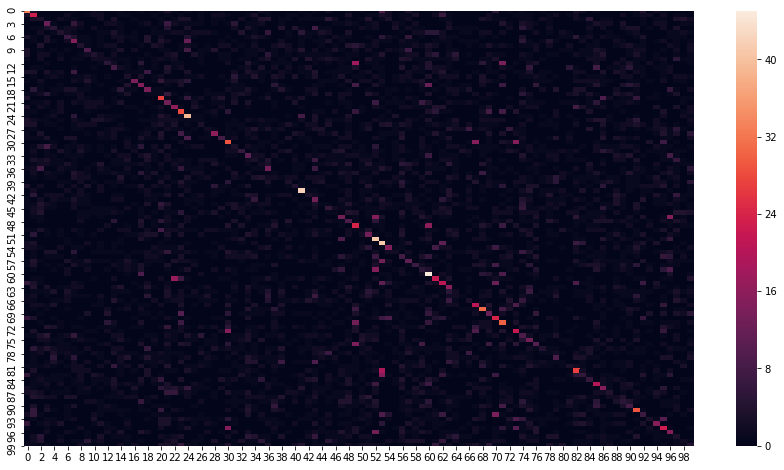

In [19]:
#Check model accuracy, F1 score, Specivity and sensitivity
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

df_cm = confusion_matrix(test_labels,y_test_preds)
df_cm = pd.DataFrame(df_cm)

plt.figure(figsize = (15,8))
sn.heatmap(df_cm)

### Test Set Classification Report

In [20]:
print(classification_report(test_labels,y_test_preds))  

              precision    recall  f1-score   support

           0       0.28      0.33      0.30       100
           1       0.14      0.23      0.17       100
           2       0.03      0.03      0.03       100
           3       0.10      0.12      0.11       100
           4       0.07      0.05      0.06       100
           5       0.06      0.04      0.05       100
           6       0.10      0.07      0.08       100
           7       0.11      0.15      0.13       100
           8       0.05      0.04      0.05       100
           9       0.11      0.09      0.10       100
          10       0.08      0.04      0.05       100
          11       0.03      0.02      0.02       100
          12       0.08      0.05      0.06       100
          13       0.08      0.08      0.08       100
          14       0.00      0.00      0.00       100
          15       0.04      0.03      0.03       100
          16       0.28      0.14      0.19       100
          17       0.12    